# Classification Notebook

## OULP-Age GEI images dataset

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib inline

mode = "train" #use train for training

In [19]:
# custom dataset class
class OULPAgeDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, "{:08}.png".format(self.dataframe.iloc[idx, 0]))
        image = Image.open(img_name)
        age = self.dataframe.iloc[idx, 1]
        label = 0 if age < 18 else 1  # 0 for Child, 1 for Adult

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
# Load the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Grayscale normalization
])
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

dataset = OULPAgeDataset(csv_file='data/OULP-Age/Age_gender_info.csv', img_dir='data/OULP-Age/GEI', transform=transform)

In [21]:
# Set a random seed
torch.manual_seed(42) # to reproduce the same exact train - test split

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print("Train Images: ", train_size)
print("Test Images: ", test_size)

Train Images:  51076
Test Images:  12770


In [22]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept grayscale images
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification: Child vs. Adult

c:\Users\PC\anaconda3\envs\laborvision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\laborvision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: GPU
Epoch 1/30, Batch 50/1597, Current Batch Loss: 0.4682
Epoch 1/30, Batch 100/1597, Current Batch Loss: 0.4220
Epoch 1/30, Batch 150/1597, Current Batch Loss: 0.3879
Epoch 1/30, Batch 200/1597, Current Batch Loss: 0.4458
Epoch 1/30, Batch 250/1597, Current Batch Loss: 0.4531
Epoch 1/30, Batch 300/1597, Current Batch Loss: 0.4401
Epoch 1/30, Batch 350/1597, Current Batch Loss: 0.3464
Epoch 1/30, Batch 400/1597, Current Batch Loss: 0.3626
Epoch 1/30, Batch 450/1597, Current Batch Loss: 0.5239
Epoch 1/30, Batch 500/1597, Current Batch Loss: 0.4156
Epoch 1/30, Batch 550/1597, Current Batch Loss: 0.5130
Epoch 1/30, Batch 600/1597, Current Batch Loss: 0.3497
Epoch 1/30, Batch 650/1597, Current Batch Loss: 0.3508
Epoch 1/30, Batch 700/1597, Current Batch Loss: 0.2252
Epoch 1/30, Batch 750/1597, Current Batch Loss: 0.4681
Epoch 1/30, Batch 800/1597, Current Batch Loss: 0.3656
Epoch 1/30, Batch 850/1597, Current Batch Loss: 0.3930
Epoch 1/30, Batch 900/1597, Current Batch Loss: 0.2303

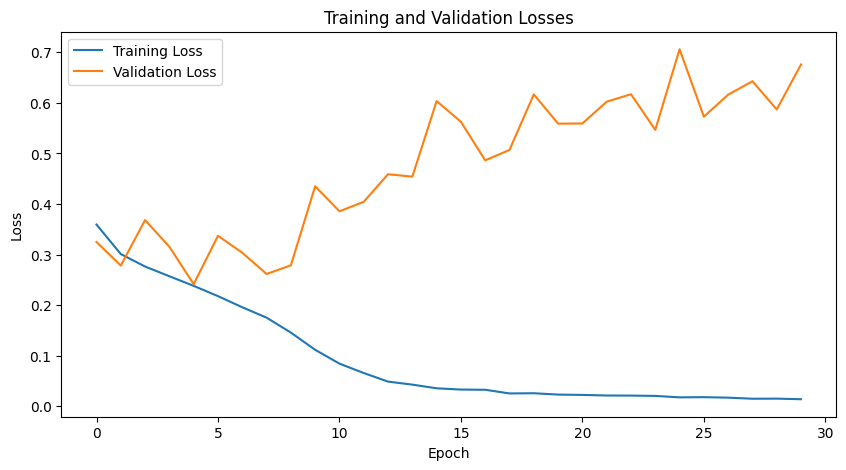

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if mode == "train":

    num_epochs = 30
    print("Device: " + "GPU" if torch.cuda.is_available() else "CPU")
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    total_batches = len(train_loader)

    # recording the tain and validation loss at every epoch 
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        
        # training loop
        running_train_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * images.size(0)

            # Print progress for every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{total_batches}, Current Batch Loss: {loss.item():.4f}")

        train_epoch_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_epoch_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
        
        val_epoch_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(val_epoch_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")
    
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

else:
    # Load the weights
    model.load_state_dict(torch.load('pretrained/greyModel.pth'))

    # Move the model to the desired device (e.g., GPU)
    model = model.to(device)

In [26]:
# evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.sigmoid(outputs) > 0.5
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

print(f"Accuracy on test data: {100 * correct / total}%")

Accuracy on test data: 89.45184025058731%


In [27]:
if mode == "train":
    torch.save(model.state_dict(), 'pretrained/latest.pth')

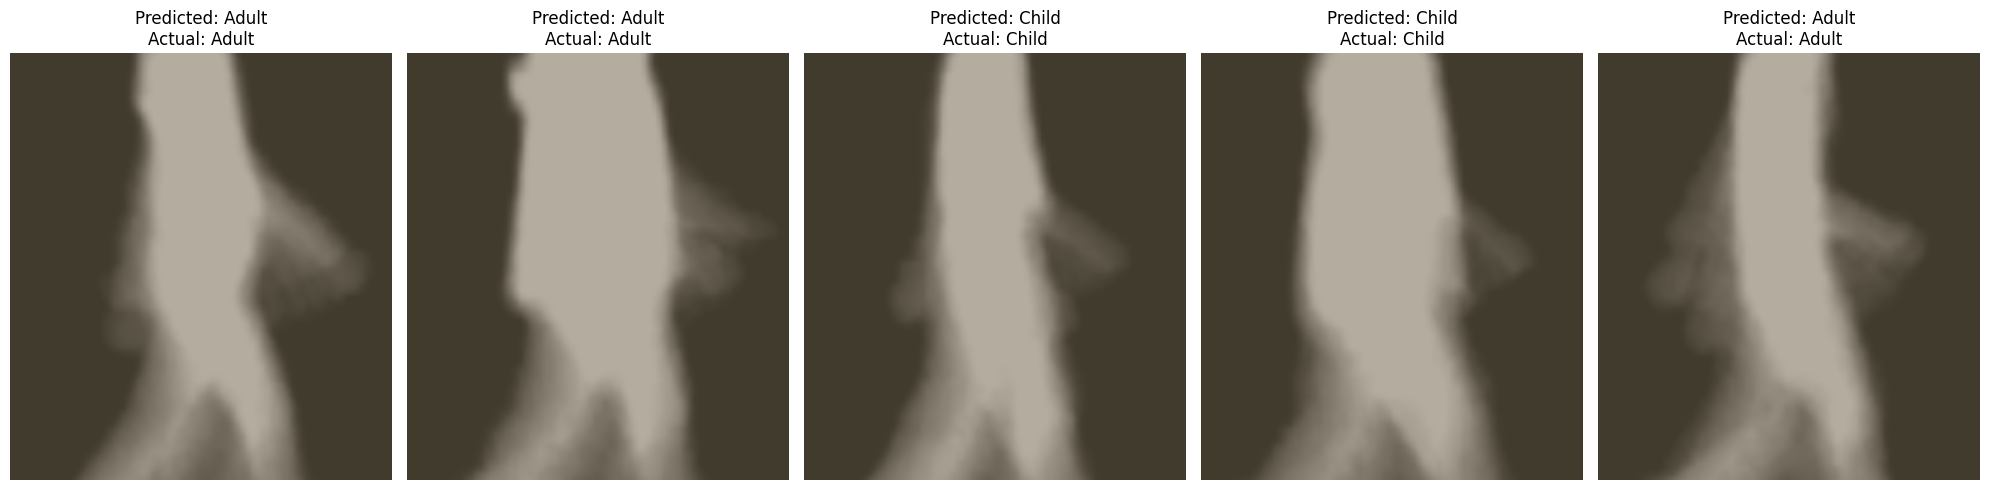

In [28]:
import random

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Convert the test_loader dataset into a list
test_data_list = list(test_loader)

# Randomly select 5 indices
random_indices = random.sample(range(len(test_data_list)), 5)

count = 0
with torch.no_grad():
    for idx in random_indices:
        images, labels = test_data_list[idx]
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted_probs = torch.sigmoid(outputs)
        predicted = predicted_probs > 0.5
        
        for i in range(images.size(0)):
            if count >= 5:
                break
            
            image = images[i].cpu().numpy().transpose((1, 2, 0))
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            predicted_class = "Child" if predicted_probs[i] < 0.5 else "Adult"
            actual_class = "Child" if labels[i] == 0 else "Adult"
            
            axes[count].imshow(image, cmap='gray', aspect='auto')
            axes[count].set_title(f"Predicted: {predicted_class}\nActual: {actual_class}")
            axes[count].axis('off')
            
            count += 1

        if count >= 5:
            break

plt.tight_layout()
plt.show()

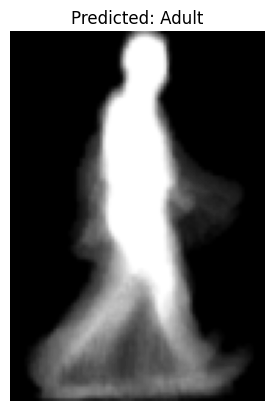

In [29]:
# example inference of one external image

#load an image
image_path = 'data/OULP-Age/GEI/00000030.png'  # Replace with your image path
image = Image.open(image_path)

# Preprocess the image
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input batch to the device (GPU or CPU) and run inference
input_batch = input_batch.to(device)
with torch.no_grad():
    output = model(input_batch)
    prob = torch.sigmoid(output)  # Get the probability
    predicted_class = "Child" if prob < 0.5 else "Adult"

# Display the image and prediction
plt.imshow(image, cmap='gray')
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

## Kaggle Children vs Adults Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [15]:
class ChildAdultDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.transform = transform
        
        # Get list of images from the "adults" and "children" directories
        self.adult_images = [os.path.join(img_dir, "adults", img) for img in os.listdir(os.path.join(img_dir, "adults"))]
        self.child_images = [os.path.join(img_dir, "children", img) for img in os.listdir(os.path.join(img_dir, "children"))]
        
        # Combine the lists and create a list of labels (0 for Child, 1 for Adult)
        self.all_images = self.child_images + self.adult_images
        self.labels = [0] * len(self.child_images) + [1] * len(self.adult_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_name = self.all_images[idx]
        image = Image.open(img_name)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [16]:
# Load the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

train_dataset = ChildAdultDataset(img_dir="data/Children-Adults-Kaggle/train", transform=transform)
test_dataset = ChildAdultDataset(img_dir="data/Children-Adults-Kaggle/test", transform=transform)

print("Train Images: ", len(train_dataset))
print("Test Images: ", len(test_dataset))

Train Images:  680
Test Images:  120


In [17]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification: Child vs. Adult

c:\Users\PC\anaconda3\envs\laborvision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\laborvision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 30
print("Device: " + "GPU" if torch.cuda.is_available() else "CPU")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
total_batches = len(train_loader)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
            # Print progress for every 10 batches (you can adjust this value as needed)
        if (batch_idx + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{total_batches}, Current Batch Loss: {loss.item():.4f}")
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Device: GPU
Epoch 1/30, Batch 20/22, Current Batch Loss: 0.4652
Epoch 1/30, Loss: 0.6164
Epoch 2/30, Batch 20/22, Current Batch Loss: 0.3346
Epoch 2/30, Loss: 0.3305
Epoch 3/30, Batch 20/22, Current Batch Loss: 0.2131
Epoch 3/30, Loss: 0.1736
Epoch 4/30, Batch 20/22, Current Batch Loss: 0.0684
Epoch 4/30, Loss: 0.1150
Epoch 5/30, Batch 20/22, Current Batch Loss: 0.1223
Epoch 5/30, Loss: 0.1614
Epoch 6/30, Batch 20/22, Current Batch Loss: 0.0457
Epoch 6/30, Loss: 0.1239
Epoch 7/30, Batch 20/22, Current Batch Loss: 0.4738
Epoch 7/30, Loss: 0.2185
Epoch 8/30, Batch 20/22, Current Batch Loss: 0.0290
Epoch 8/30, Loss: 0.1054
Epoch 9/30, Batch 20/22, Current Batch Loss: 0.0590
Epoch 9/30, Loss: 0.0632
Epoch 10/30, Batch 20/22, Current Batch Loss: 0.0133
Epoch 10/30, Loss: 0.0216
Epoch 11/30, Batch 20/22, Current Batch Loss: 0.0010
Epoch 11/30, Loss: 0.0153
Epoch 12/30, Batch 20/22, Current Batch Loss: 0.0019
Epoch 12/30, Loss: 0.0178
Epoch 13/30, Batch 20/22, Current Batch Loss: 0.0098
Epoch

In [20]:
# evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.sigmoid(outputs) > 0.5
        total += labels.size(0)
        correct += (predicted == labels.unsqueeze(1)).sum().item()

print(f"Accuracy on test data: {100 * correct / total}%")

Accuracy on test data: 81.66666666666667%


In [23]:
torch.save(model.state_dict(), 'pretrained/kaggle.pth')

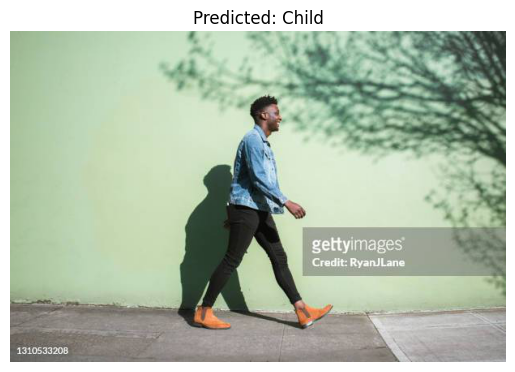

In [24]:
# Exmple Inference

#load an image
image_path = 'inputs/test3.jpg'  # Replace with your image path
image = Image.open(image_path)

# Preprocess the image
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input batch to the device (GPU or CPU) and run inference
input_batch = input_batch.to(device)
with torch.no_grad():
    output = model(input_batch)
    prob = torch.sigmoid(output)  # Get the probability
    predicted_class = "Child" if prob < 0.5 else "Adult"

# Display the image and prediction
plt.imshow(image, cmap='gray')
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()